In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [14]:
# Generate valid and invalid data and put it in a file
def write_csv_file(in_file, out_file):
    
    studynumbers = []
    names = []
    
    with open(in_file, "r") as inputfile:
        ln = 1
        for line in inputfile:
            if ln > 1:
                entry = line.split(",") # Set spaces as delimiter between numbers
                studynumbers.append(entry[0])
                names.append(entry[1])
            ln += 1
                
                
    with open(out_file, "w") as outputfile:
        n = len(studynumbers)
        m = 10
        seven_step = [12, 12, 12, 10, 10, 10, 10, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 0, 0, 0, -3]

        header = 'StudentID,Name,'
        for k in range(1, m+1): 
            header += 'Assignment' + str(k) + ','
        outputfile.write(header[:-1] + "\n") # Minus the last comma

        for i in range(n):
            studyno = 's' + studynumbers[i]
            name = names[i]
            line = ('{0},{1},').format(studyno, name)
            for j in range(m):
                line += str(random.choice(seven_step)) + ','
            outputfile.write(line[:-1] + "\n")

In [15]:
write_csv_file('file.csv', 'newfile.csv')

In [16]:
def roundGrade(grades):
    # Seven step scale for reference
    seven_step = [12, 10, 7, 4, 2, 0, -3]
    rounded = []
    
    # Find nearest match for each input grade. Round up if it's a tie.
    for grade in grades:
        nearest = min(seven_step, key=lambda x:abs(x - grade))
        rounded.append(nearest)
        
    return rounded

In [207]:
def computeFinalGrades(grades):
    # If less than 2 assignments, return the original grades
    grades = np.array(grades)
    if np.ndim(grades) <= 1: 
        return grades 
    
    students = np.array(grades).shape[0]
    assignments = np.array(grades).shape[1]
    filtered_grades = []
    
    # For each student, check if they have gotten a -3
    for i in range(students):
        if -3 in grades[i]:
            filtered_grades.append([-3] * assignments)
        else:
            filtered_grades.append(grades[i])
    
    # Take sum of the filtered grades and subtract the worst grade
    grade_sums = np.sum(np.array(filtered_grades), axis=1) - np.min(np.array(filtered_grades), axis=1)
    
    # Mean Grades = Sum of Grades / Assignments - 1 (Since one grade was removed)
    return roundGrade(grade_sums / (assignments - 1))

In [208]:
# Prevents grades from overlapping once plotted, by adding a small factor
def fixDuplicates(row):
    seen = []
    for i in range(len(row)):
        # If grade has already been seen, adjust the grade slightly
        if row[i] in seen:
            row[i] += np.random.uniform(-0.1, 0.1)
        else: seen.append(row[i])
    return row

In [209]:
def randomColor():
    # Produces a random hex color code. Used when plotting assignment mean grade.
    return '#' + ''.join([random.choice('0123456789ABCDEF') for x in range(6)])

In [210]:
def loadGrades(filename):
    # Read file contents into a Pandas Dataframe
    df = pd.read_csv(filename)
    grade_df = df
    
    # M = Number of Assignments
    M = len(df.columns) - 2
    
    # 7-step scale for reference
    seven_step = [12, 10, 7, 4, 2, 0, -3]

    # Grades matrix, and error list
    all_grades = []
    errors = []
    seen_students = []
        
    # Iterate through dataframe rows
    for student_row in df.itertuples():
        
        # Row number is given by the first element in the dataframe
        row_no = student_row[0]
        
        # Student number is the second element in the dataframe
        student_no = student_row[1]
        
        # If duplicate entry for student name throw error and don't read the row
        if student_no in seen_students:
            duplicate_err = "DUPLICATE ERROR: Duplicate entry for student " + student_no + " on line " + str(row_no + 1)
            errors.append(duplicate_err)
            # Remove the student data from the grade dataframe
            grade_df = grade_df.drop(df.index[row_no])
            
        # If not a duplicate, try and parse the row
        else:
            seen_students.append(student_no)
            try:
                # Check that all elements are numbers, and that they are a valid 7-step grade.
                # Pandas reads missing columns as the value 'NaN'.
                grade_row = [int(x) for x in student_row[3:M+3] if int(x) in seven_step]
                
                # Check that all numbers read very valid grades
                if len(grade_row) == M:
                    all_grades.append(grade_row)
                else:
                    value_err = "VALUE ERROR: Row contains non valid grade on line " + str(row_no + 1)
                    errors.append(value_err)
                    # Remove the student data from the grade dataframe
                    grade_df = grade_df.drop(df.index[row_no])
                    
            # If not a number -> Save error
            except ValueError:
                parse_err = "PARSE ERROR: Row contains non-number as a grade, or is missing a grade on line " + str(row_no + 1)
                errors.append(parse_err)
                # Remove the student data from the grade dataframe
                grade_df = grade_df.drop(df.index[row_no])
            
    return [all_grades, grade_df, errors]

In [211]:
def displayGrades(grade_matrix):
    # Data frame is at index 1 in array from loadGrades
    df = grade_matrix[1]
    df['Final Grade'] = computeFinalGrades(grade_matrix[0])
    print(df.sort_values(["Name"], ascending=True).to_string())

In [212]:
def displayDataErrors(grades_matrix):
    errors = grades_matrix[2]
    for error in errors:
        print(error)

In [213]:
# Plots a bar plot
def barPlot(grades):
    data = computeFinalGrades(grades)
    seven_step = [-3, 0, 2, 4, 7, 10, 12]

    plt.hist(data, bins = range(min(data), max(data) + 1))
    plt.xticks(seven_step)
    plt.title("Final Grades for All Students")
    plt.xlabel("Grade on the 7-step Scale")
    plt.ylabel("Number of Students")
    plt.show()

# Plots a linear plot
def linearPlot(grades):
    grades = np.array(grades)
    students = grades.shape[0]
    assignments = grades.shape[1]
    
    # Each assignment grade gets the same color as the vertical line representing the mean grade
    colors = [randomColor() for i in range(assignments)]
    labels = []
    for i in range(assignments):
        assignment_title = "A" + str(i + 1)
        x = [i] * students # Add one x point for each assignment
        y = fixDuplicates(grades[:,i]) # Columns = assignment grades
        labels.append(assignment_title)
        
        plt.axhline(y=np.mean(grades[i]), color=colors[i], linestyle='-', label = assignment_title + " mean grade")
        plt.plot(x, y, '.', color=colors[i])

    plt.xticks(range(assignments), labels)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("All Assignment Grades")
    plt.xlabel("Assignment Number")
    plt.ylabel("Grade on the 7-step Scale")
    plt.show()
    

# Makes a barplot and a linear plot.
def gradesPlot(grades):
    barPlot(grades)
    linearPlot(grades)

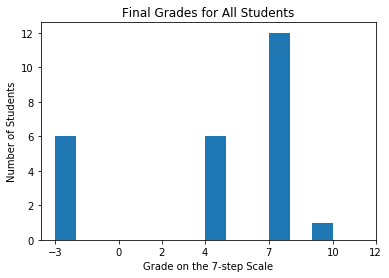

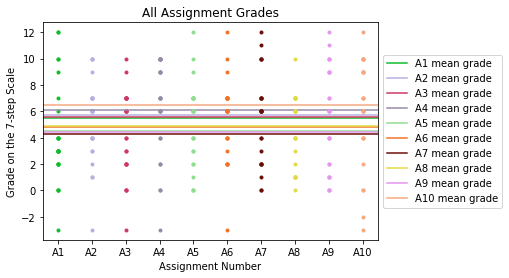

In [214]:
read_data = loadGrades('badfile.csv')
read_data[2]
np.array(read_data[0]).shape
gradesPlot(read_data[0])

In [215]:
displayGrades(read_data)

   StudentID        Name  A1  A2  A3  A4  A5  A6  A7  A8  A9   A10  Final Grade
0    s000000   Student 0   4   7   7  10   7   7   2   2   2   7.0            7
1    s000001   Student 1   4   7   7  10   7   7   2   2   2  10.0            7
9    s000010  Student 10   4   4  -3  10   7   7   2   7   7   7.0           -3
10   s000011  Student 11   0   4   7  10   2   4   7   4   7   4.0            4
11   s000012  Student 12  10  10   7   7   4   7   7   4   0  10.0            7
12   s000013  Student 13  12   7   2   7   7   7   4   7   4   4.0            7
13   s000014  Student 14   2   7   4  10  12  10  12   4   2   7.0            7
14   s000015  Student 15  -3   4   7   2   0  10   7   7  12  10.0           -3
17   s000017  Student 17   7  -3   4   2  10   7   7   7   0  10.0           -3
18   s000018  Student 18   4   4   2   7   4   2   0   7   2  10.0            4
2    s000002   Student 2   4   7   7  10   7   7   2   2   2  10.0            7
19   s000020  Student 20   2   4   4   7

In [216]:
displayDataErrors(read_data)

PARSE ERROR: Row contains non-number as a grade, or is missing a grade on line 6
VALUE ERROR: Row contains non valid grade on line 7
DUPLICATE ERROR: Duplicate entry for student s000015 on line 16
PARSE ERROR: Row contains non-number as a grade, or is missing a grade on line 17


In [217]:
import os.path

filename = "text.csv"
extension = os.path.splitext(filename)[1]
extension

'.csv'

In [218]:
k = 8
l = 2
print('Jeg er {k} år gammel og har {l} hunde')




Jeg er {k} år gammel og har {l} hunde


In [219]:
print(p)

['jeg', 'er', 'tre', 'år']


In [220]:

k = [1,4]
p = ['jeg', 'er', 'tre', 'år']
[x for x in p if p.index(x)+1 in k] 

['jeg', 'år']

In [221]:
k = 0
j = 0
while j < 5:
    j += 1
    repeat
    k += 1


SyntaxError: 'return' outside function (<ipython-input-221-e6455396a192>, line 5)

In [23]:
df = pd.read_csv('newfile.csv')
print(df.to_string(index=False))

StudentID                 Name  Assignment1  Assignment2  Assignment3  Assignment4  Assignment5  Assignment6  Assignment7  Assignment8  Assignment9  Assignment10
 s154393         Isaac Newman           10            7            7            4            4            4            7           10            0             7
 s115245   Sofia Kovalevskaya            7            4            4            7            7            7            7           10            7             4
 s120578          Ida Haendel           10           12            7            0            7            4            2            2            0            -3
 s124444        Ebn Meskavayh            7            7            7            2            7            4            7            7            7            12
 s146322     Eleanora Romanov           -3           -3            7            7            7           -3            4           12            2            -3
 s125442      Haruki Murakami    

In [6]:
sd = [12, 10, 7, 7, 7, 7, 7, 4, 2, 0, -3]
sum(sd) / len(sd)

5.454545454545454

In [3]:
sd = [12, 10, 7, 4, 2]
sum(sd) / len(sd)

7.0

In [8]:
import numpy as np
np.random.normal(, sigma, 10)

NameError: name 'mu' is not defined

In [17]:
k = "{0} er lig {1}"
k.format(9, 1)

'9 er lig 1'

In [18]:
k = [1,2,3,4]
j = 1.0
j in k

True

In [19]:
float(1)

1.0

In [22]:
float("1.231")

1.231

In [23]:
float("das")

ValueError: could not convert string to float: 'das'

In [24]:
"Hd7DA".lower()

'hd7da'

In [25]:
a = NaN

NameError: name 'NaN' is not defined

In [26]:
k = "12"
k.isnull()

AttributeError: 'str' object has no attribute 'isnull'

In [28]:
n = float('nan')

In [29]:
float(n)

nan

In [30]:
i = float('nan')

In [32]:
n == float('nan')

False